## Complex Navier Stokes equations
In the following code I modify the basic configuration of the vein model to use a function as upper limit and lower limit

In [1]:
# Librerias necesarias
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap

In [17]:
# Constantes
N_POINTS = 65  # Numero de puntos en cada dirección
# ==========================================
#DOMAIN_SIZE = 15.0 Tamaño del dominio 
DOMAIN_SIZE_X = 10.0  # Tamaño del dominio en X
DOMAIN_SIZE_Y = 1.0  # Tamaño del dominio en Y
# ==========================================
N_ITERATIONS = 500 # Numero de iteraciones
TIME_STEP_LENGTH = 0.001  # Longitud del paso de tiempo
KINEMATIC_VISCOSITY = 0.05 # Viscosidad cinemática (0.1 para flujo laminar, 0.5 para más turbulento)
DENSITY = 1.0 # Densidad del fluido (1.0 para fluido genérico)
# HORINZONTAL_VELOCITY_TOP = 1.0
PRESSURE_GRADIENT = -1  # Gradiente de presión que impulsa el flujo
N_PRESSURE_POISSON_ITERATION = 50  # Iteraciones para resolver la ecuación de Poisson
INLET_VELOCITY = 0.5  # Velocidad en la entrada


def main_1():
    element_length = DOMAIN_SIZE_Y / (N_POINTS - 1) # Cambio aquí para Y
    
    # Crear la malla
    x = np.linspace(0.0, DOMAIN_SIZE_X, N_POINTS)
    y = np.linspace(0.0, DOMAIN_SIZE_Y, N_POINTS)
    X, Y = np.meshgrid(x, y)
    
    # Inicializar campos
    u_prev = np.zeros_like(X)
    v_prev = np.zeros_like(X)
    p_prev = np.zeros_like(X)

    # Aplicar gradiente de presión lineal en X
    for i in range(N_POINTS):
        p_prev[:, i] = PRESSURE_GRADIENT * x[i]

    # Funciones de diferencias finitas 
    def central_difference_x(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[1:-1, 2:] - f[1:-1, 0:-2]) / (2 * element_length)
        return diff

    def central_difference_y(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[2:, 1:-1] - f[0:-2, 1:-1]) / (2 * element_length)
        return diff

    def laplace(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (
            f[1:-1, 0:-2] + f[0:-2, 1:-1] - 4 * f[1:-1, 1:-1] + 
            f[1:-1, 2:] + f[2:, 1:-1]) / (element_length ** 2)
        return diff
    
    # Nuevo
    maximun_possible_time_step_length = (
        0.5 * element_length**2 / KINEMATIC_VISCOSITY
    )
    if TIME_STEP_LENGTH > maximun_possible_time_step_length:
        raise RuntimeError("<INF> Stability is not guarenteend")


    # Simulación principal
    for i in tqdm(range(N_ITERATIONS)):


        # Calcular derivadas
        d_u_prev_d_x = central_difference_x(u_prev)
        d_u_prev_d_y = central_difference_y(u_prev)
        d_v_prev_d_x = central_difference_x(v_prev)
        d_v_prev_d_y = central_difference_y(v_prev)
        d_p_prev_d_x = central_difference_x(p_prev)
        
        laplace_u_prev = laplace(u_prev)
        laplace_v_prev = laplace(v_prev)

        # Paso de velocidad CON GRADIENTE DE PRESIÓN
        u_tent = u_prev + TIME_STEP_LENGTH * (
            -(u_prev * d_u_prev_d_x + v_prev * d_u_prev_d_y) 
            #- (1/DENSITY) * d_p_prev_d_x  Término de presión
            + KINEMATIC_VISCOSITY * laplace_u_prev
        )
        
        v_tent = v_prev + TIME_STEP_LENGTH * (
            -(u_prev * d_v_prev_d_x + v_prev * d_v_prev_d_y) 
            + KINEMATIC_VISCOSITY * laplace_v_prev
        )

        # CONDICIONES DE FRONTERA PARA EL FLUJO
        # Paredes superior e inferior: NO MOVIMIENTO
        u_tent[0, :] = 0.0                    # Inferior
        u_tent[-1, :] = 0.0                   # Superior
        
        # Laterales: periódicas
        u_tent[:, 0] = u_tent[:, -2]          
        u_tent[:, -1] = u_tent[:, 1]          
        
        v_tent[0, :] = 0.0                    # Inferior
        v_tent[-1, :] = 0.0                   # Superior
        v_tent[:, 0] = v_tent[:, -2]          # Izquierda
        v_tent[:, -1] = v_tent[:, 1]          # Derecha

        # Calcular RHS para ecuación de Poisson
        d_u_tent_d_x = central_difference_x(u_tent)
        d_v_tent_d_y = central_difference_y(v_tent)
        
        rhs = DENSITY / TIME_STEP_LENGTH * (d_u_tent_d_x + d_v_tent_d_y)

        # Resolver ecuación de Poisson para presión Corregido
        p_next = p_prev.copy()
        for _ in range(N_PRESSURE_POISSON_ITERATION):
            p_old = p_next.copy()
            p_next[1:-1, 1:-1] = 1/4 * (
                p_old[1:-1, 0:-2] + p_old[0:-2, 1:-1] + 
                p_old[1:-1, 2:] + p_old[2:, 1:-1] - 
                element_length ** 2 * rhs[1:-1, 1:-1]
            )
            
            # Condiciones de frontera para presión
            p_next[:, 0] = p_next[:, 1] + PRESSURE_GRADIENT * element_length  # Entrada
            p_next[:, -1] = p_next[:, -2]  # Salida (referencia = 0)
            p_next[0, :] = p_next[1, :]    # Pared inferior (Neumann)
            p_next[-1, :] = p_next[-2, :]  # Pared superior (Neumann)
        # Corrección de velocidad
        # Corrección de velocidad con gradiente de presión
        d_p_next_d_x = central_difference_x(p_next)
        d_p_next_d_y = central_difference_y(p_next)
        
        u_next = u_tent - TIME_STEP_LENGTH / DENSITY * d_p_next_d_x
        v_next = v_tent - TIME_STEP_LENGTH / DENSITY * d_p_next_d_y

        # Aplicar condiciones de frontera finales
        u_next[0, :] = 0.0    # Inferior
        u_next[-1, :] = 0.0   # Superior
        u_next[:, 0] = u_next[:, -2]
        u_next[:, -1] = u_next[:, 1]
        
        v_next[0, :] = 0.0    # Inferior
        v_next[-1, :] = 0.0   # Superior
        v_next[:, 0] = v_next[:, -2]
        v_next[:, -1] = v_next[:, 1]


        # Entrada
        for j in range(N_POINTS):
            y_pos = y[j]
            u_next[j, 0] = INLET_VELOCITY * 4 * y_pos * (DOMAIN_SIZE_Y - y_pos) / (DOMAIN_SIZE_Y**2)
        v_next[:, 0] = 0.0
        
        # Salida
        u_next[:, -1] = u_next[:, -2]
        v_next[:, -1] = v_next[:, -2]

        # Actualizar para siguiente iteración
        u_prev = u_next
        v_prev = v_next
        p_prev = p_next

    return u_next, v_next, p_next, X, Y

if __name__ == "__main__":
    u_next, v_next, p_next, X, Y = main_1()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:01<00:00, 259.59it/s]


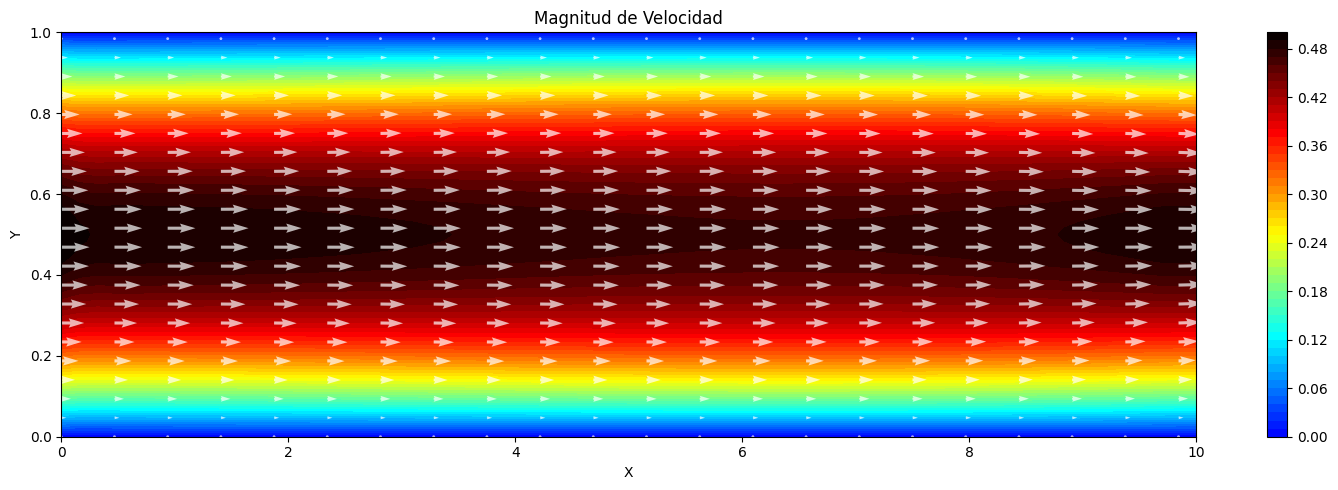

In [23]:
            #************Graficar****************
fig, ax = plt.subplots(figsize=(15, 5)) # Figura alargada

velocity_magnitude = np.sqrt(u_next**2 + v_next**2)

    # Colormap (Azul fuerte, Verde, Amarillo, Rojo, negro)
black_red = LinearSegmentedColormap.from_list("black_red", ["blue","cyan","yellow", "red", "black"])

    # 2. Magnitud de velocidad
contour = ax.contourf(X, Y, velocity_magnitude, levels=50, cmap=black_red, alpha=1.0)
ax.quiver(X[::3, ::3], Y[::3, ::3], u_next[::3, ::3], v_next[::3, ::3],
            scale=20, color='white', alpha=0.7) # Flechas de velocidad
ax.set_title('Magnitud de Velocidad')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.colorbar(contour, ax=ax)

plt.tight_layout()
plt.show()